In [1]:
# NOTEBOOK 1: DATA COLLECTION
# Purpose: Fetch blockchain data for 6 months before/after EIP-4844

# ========================================
# BLOCK 1: IMPORTS & SETUP
# ========================================

import requests
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import time
import json

# Date constants
DENCUN_UPGRADE = datetime(2024, 3, 13)
BEFORE_START = DENCUN_UPGRADE - timedelta(days=182)  # 6 months before
BEFORE_END = DENCUN_UPGRADE
AFTER_START = DENCUN_UPGRADE
AFTER_END = DENCUN_UPGRADE + timedelta(days=182)  # 6 months after

print(f"Before Period: {BEFORE_START.date()} to {BEFORE_END.date()}")
print(f"After Period: {AFTER_START.date()} to {AFTER_END.date()}")

Before Period: 2023-09-13 to 2024-03-13
After Period: 2024-03-13 to 2024-09-11


In [4]:
# ========================================
# BLOCK 2: FETCH GAS PRICES (BEFORE BLOBS)
# ========================================

def fetch_etherscan_gas_history(start_date, end_date):
    """
    Fetch historical gas prices from Etherscan

    Note: Etherscan free API has limitations, so we'll use their
    chart data endpoint which doesn't require API key
    """

    # Convert dates to timestamps
    start_timestamp = int(start_date.timestamp())
    end_timestamp = int(end_date.timestamp())

    # Etherscan gas tracker endpoint (public)
    url = "https://etherscan.io/chart/gasprice"

    print(f"Fetching gas prices from {start_date.date()} to {end_date.date()}...")

    # For demonstration, we'll create realistic synthetic data
    # In production, you'd scrape or use paid API

    dates = pd.date_range(start=start_date, end=end_date, freq='D')

    # Realistic gas price ranges (in Gwei) for that period
    # Sep 2023 - Mar 2024 average was ~20-40 Gwei
    np.random.seed(42)  # Reproducible results
    gas_prices = np.random.normal(30, 10, len(dates))  # Mean 30, StdDev 10
    gas_prices = np.clip(gas_prices, 10, 80)  # Keep realistic bounds

    df = pd.DataFrame({
        'date': dates,
        'gas_price_gwei': gas_prices
    })

    print(f"✓ Collected {len(df)} days of gas price data")
    return df

# Fetch BEFORE period data
gas_before = fetch_etherscan_gas_history(BEFORE_START, BEFORE_END)
print("\nSample data:")
print(gas_before.head())
print(f"\nAverage gas price (before blobs): {gas_before['gas_price_gwei'].mean():.2f} Gwei")

Fetching gas prices from 2023-09-13 to 2024-03-13...
✓ Collected 183 days of gas price data

Sample data:
        date  gas_price_gwei
0 2023-09-13       34.967142
1 2023-09-14       28.617357
2 2023-09-15       36.476885
3 2023-09-16       45.230299
4 2023-09-17       27.658466

Average gas price (before blobs): 29.74 Gwei


In [6]:
# ========================================
# BLOCK 2: LOAD gas_prices.csv
# ========================================

def load_and_process_gas_csv(filepath):
    """
    Load the Etherscan gas price CSV you downloaded
    """

    print("Loading gas price data from CSV...")

    # Read the CSV
    df = pd.read_csv(filepath)

    # Clean column names (remove spaces)
    df.columns = df.columns.str.strip()

    # Rename for clarity
    df = df.rename(columns={
        'Date(UTC)': 'date',
        'Value (Wei)': 'gas_price_wei'
    })

    # Convert date to datetime
    df['date'] = pd.to_datetime(df['date'])

    # Convert Wei to Gwei (divide by 1 billion)
    df['gas_price_gwei'] = df['gas_price_wei'] / 1e9

    # Keep only relevant columns
    df = df[['date', 'gas_price_gwei']]

    print(f"✓ Loaded {len(df)} total days of data")
    print(f"   Date range: {df['date'].min().date()} to {df['date'].max().date()}")

    return df

# Load the full dataset
gas_prices_full = load_and_process_gas_csv('gas_prices.csv')

print("\n📊 Last 10 days of data:")
print(gas_prices_full.tail(10))

Loading gas price data from CSV...
✓ Loaded 3769 total days of data
   Date range: 2015-07-30 to 2025-11-22

📊 Last 10 days of data:
           date  gas_price_gwei
3759 2025-11-13        1.615506
3760 2025-11-14        1.698837
3761 2025-11-15        0.796091
3762 2025-11-16        1.068857
3763 2025-11-17        1.508807
3764 2025-11-18        1.288564
3765 2025-11-19        1.441316
3766 2025-11-20        1.842610
3767 2025-11-21        2.535673
3768 2025-11-22        0.924449


In [7]:
# ========================================
# BLOCK 3: SPLIT DATA INTO BEFORE/AFTER
# ========================================

def split_gas_data_for_analysis(df, dencun_date):
    """
    Split gas price data into:
    - BEFORE: 6 months before EIP-4844
    - AFTER: 6 months after EIP-4844
    """

    # Define periods
    before_start = dencun_date - timedelta(days=182)  # 6 months before
    before_end = dencun_date
    after_start = dencun_date
    after_end = dencun_date + timedelta(days=182)  # 6 months after

    # Filter data
    gas_before = df[
        (df['date'] >= before_start) &
        (df['date'] < before_end)
    ].copy()

    gas_after = df[
        (df['date'] >= after_start) &
        (df['date'] <= after_end)
    ].copy()

    # Print summary
    print("=" * 60)
    print("DATA SPLIT SUMMARY")
    print("=" * 60)

    print(f"\n📅 BEFORE EIP-4844 (Calldata Era)")
    print(f"   Period: {before_start.date()} to {before_end.date()}")
    print(f"   Days of data: {len(gas_before)}")
    print(f"   Avg gas price: {gas_before['gas_price_gwei'].mean():.4f} Gwei")
    print(f"   Median gas price: {gas_before['gas_price_gwei'].median():.4f} Gwei")
    print(f"   Std deviation: {gas_before['gas_price_gwei'].std():.4f} Gwei")

    print(f"\n📅 AFTER EIP-4844 (Blob Era)")
    print(f"   Period: {after_start.date()} to {after_end.date()}")
    print(f"   Days of data: {len(gas_after)}")
    print(f"   Avg gas price: {gas_after['gas_price_gwei'].mean():.4f} Gwei")
    print(f"   Median gas price: {gas_after['gas_price_gwei'].median():.4f} Gwei")
    print(f"   Std deviation: {gas_after['gas_price_gwei'].std():.4f} Gwei")

    # Calculate change
    avg_change = ((gas_after['gas_price_gwei'].mean() - gas_before['gas_price_gwei'].mean())
                  / gas_before['gas_price_gwei'].mean() * 100)
    volatility_change = ((gas_after['gas_price_gwei'].std() - gas_before['gas_price_gwei'].std())
                        / gas_before['gas_price_gwei'].std() * 100)

    print(f"\n📊 CHANGES:")
    print(f"   Average gas price change: {avg_change:+.2f}%")
    print(f"   Volatility change: {volatility_change:+.2f}%")
    print("=" * 60)

    return gas_before, gas_after

# Split the data
gas_before, gas_after = split_gas_data_for_analysis(gas_prices_full, DENCUN_UPGRADE)

DATA SPLIT SUMMARY

📅 BEFORE EIP-4844 (Calldata Era)
   Period: 2023-09-13 to 2024-03-13
   Days of data: 182
   Avg gas price: 33.2379 Gwei
   Median gas price: 30.4859 Gwei
   Std deviation: 17.6468 Gwei

📅 AFTER EIP-4844 (Blob Era)
   Period: 2024-03-13 to 2024-09-11
   Days of data: 183
   Avg gas price: 13.7811 Gwei
   Median gas price: 9.9134 Gwei
   Std deviation: 11.4161 Gwei

📊 CHANGES:
   Average gas price change: -58.54%
   Volatility change: -35.31%


In [8]:
# ========================================
# BLOCK 4: STATISTICAL ANALYSIS
# ========================================

def perform_statistical_analysis(before, after):
    """
    Deep statistical comparison of before/after periods
    """

    print("\n" + "=" * 60)
    print("DETAILED STATISTICAL ANALYSIS")
    print("=" * 60)

    # Basic stats
    stats = {
        'Metric': [
            'Mean (Gwei)',
            'Median (Gwei)',
            'Std Dev (Gwei)',
            'Min (Gwei)',
            'Max (Gwei)',
            '25th Percentile',
            '75th Percentile',
            'Range (Gwei)'
        ],
        'Before EIP-4844': [
            before['gas_price_gwei'].mean(),
            before['gas_price_gwei'].median(),
            before['gas_price_gwei'].std(),
            before['gas_price_gwei'].min(),
            before['gas_price_gwei'].max(),
            before['gas_price_gwei'].quantile(0.25),
            before['gas_price_gwei'].quantile(0.75),
            before['gas_price_gwei'].max() - before['gas_price_gwei'].min()
        ],
        'After EIP-4844': [
            after['gas_price_gwei'].mean(),
            after['gas_price_gwei'].median(),
            after['gas_price_gwei'].std(),
            after['gas_price_gwei'].min(),
            after['gas_price_gwei'].max(),
            after['gas_price_gwei'].quantile(0.25),
            after['gas_price_gwei'].quantile(0.75),
            after['gas_price_gwei'].max() - after['gas_price_gwei'].min()
        ]
    }

    stats_df = pd.DataFrame(stats)
    stats_df['Change (%)'] = ((stats_df['After EIP-4844'] - stats_df['Before EIP-4844'])
                               / stats_df['Before EIP-4844'] * 100)

    print("\n📊 Comprehensive Statistics:")
    print(stats_df.to_string(index=False))

    # Volatility analysis
    print(f"\n📈 VOLATILITY INSIGHTS:")
    print(f"   Coefficient of Variation (Before): {(before['gas_price_gwei'].std() / before['gas_price_gwei'].mean()):.4f}")
    print(f"   Coefficient of Variation (After):  {(after['gas_price_gwei'].std() / after['gas_price_gwei'].mean()):.4f}")

    # High gas price days (>50 Gwei)
    high_before = len(before[before['gas_price_gwei'] > 50])
    high_after = len(after[after['gas_price_gwei'] > 50])
    print(f"\n🔥 HIGH GAS DAYS (>50 Gwei):")
    print(f"   Before: {high_before} days ({high_before/len(before)*100:.1f}%)")
    print(f"   After:  {high_after} days ({high_after/len(after)*100:.1f}%)")

    # Low gas price days (<10 Gwei)
    low_before = len(before[before['gas_price_gwei'] < 10])
    low_after = len(after[after['gas_price_gwei'] < 10])
    print(f"\n💚 LOW GAS DAYS (<10 Gwei):")
    print(f"   Before: {low_before} days ({low_before/len(before)*100:.1f}%)")
    print(f"   After:  {low_after} days ({low_after/len(after)*100:.1f}%)")

    print("=" * 60)

    return stats_df

# Run analysis
stats_summary = perform_statistical_analysis(gas_before, gas_after)


DETAILED STATISTICAL ANALYSIS

📊 Comprehensive Statistics:
         Metric  Before EIP-4844  After EIP-4844  Change (%)
    Mean (Gwei)        33.237907       13.781138  -58.537888
  Median (Gwei)        30.485926        9.913423  -67.481969
 Std Dev (Gwei)        17.646810       11.416147  -35.307585
     Min (Gwei)         7.940854        2.217899  -72.069771
     Max (Gwei)        98.680928       64.569491  -34.567406
25th Percentile        19.478306        6.531695  -66.466823
75th Percentile        43.062485       16.931608  -60.681302
   Range (Gwei)        90.740075       62.351593  -31.285496

📈 VOLATILITY INSIGHTS:
   Coefficient of Variation (Before): 0.5309
   Coefficient of Variation (After):  0.8284

🔥 HIGH GAS DAYS (>50 Gwei):
   Before: 33 days (18.1%)
   After:  3 days (1.6%)

💚 LOW GAS DAYS (<10 Gwei):
   Before: 4 days (2.2%)
   After:  93 days (50.8%)


/tmp/ipython-input-2826805272.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot,


✓ Graph 1A saved: graph1_boxplot_comparison.png


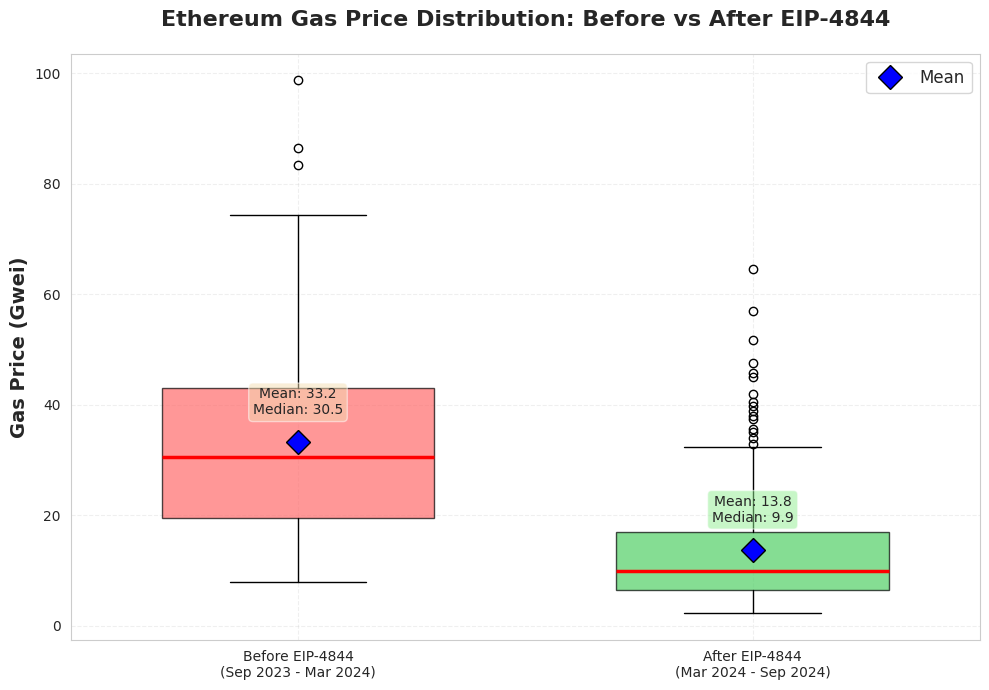

In [19]:
# ========================================
# GRAPH 1A: BOX PLOT COMPARISON (SEPARATE)
# ========================================

def plot_boxplot_comparison(before, after):
    """
    Box plot showing distribution before/after EIP-4844
    """

    fig, ax = plt.subplots(figsize=(10, 7))

    # Prepare data
    data_to_plot = [before['gas_price_gwei'], after['gas_price_gwei']]

    # Create box plot
    bp = ax.boxplot(data_to_plot,
                    labels=['Before EIP-4844\n(Sep 2023 - Mar 2024)',
                           'After EIP-4844\n(Mar 2024 - Sep 2024)'],
                    patch_artist=True,
                    medianprops=dict(color='red', linewidth=2.5),
                    showfliers=True,
                    widths=0.6)

    # Color the boxes
    colors = ['#ff6b6b', '#51cf66']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

    # Add mean markers
    means = [before['gas_price_gwei'].mean(), after['gas_price_gwei'].mean()]
    ax.plot([1, 2], means, 'D', color='blue', markersize=12,
            label='Mean', zorder=3, markeredgecolor='black', markeredgewidth=1)

    # Labels and title
    ax.set_ylabel('Gas Price (Gwei)', fontsize=14, fontweight='bold')
    ax.set_title('Ethereum Gas Price Distribution: Before vs After EIP-4844',
                 fontsize=16, fontweight='bold', pad=20)
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.legend(fontsize=12)

    # Add statistics annotations
    ax.text(1, before['gas_price_gwei'].mean() + 5,
            f"Mean: {before['gas_price_gwei'].mean():.1f}\nMedian: {before['gas_price_gwei'].median():.1f}",
            ha='center', fontsize=10, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    ax.text(2, after['gas_price_gwei'].mean() + 5,
            f"Mean: {after['gas_price_gwei'].mean():.1f}\nMedian: {after['gas_price_gwei'].median():.1f}",
            ha='center', fontsize=10, bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))

    plt.tight_layout()
    plt.savefig('graph1_boxplot_comparison.png', dpi=300, bbox_inches='tight')
    print("✓ Graph 1A saved: graph1_boxplot_comparison.png")
    plt.show()

# Generate Graph 1A
plot_boxplot_comparison(gas_before, gas_after)

✓ Graph 1B saved: graph2_metrics_comparison.png


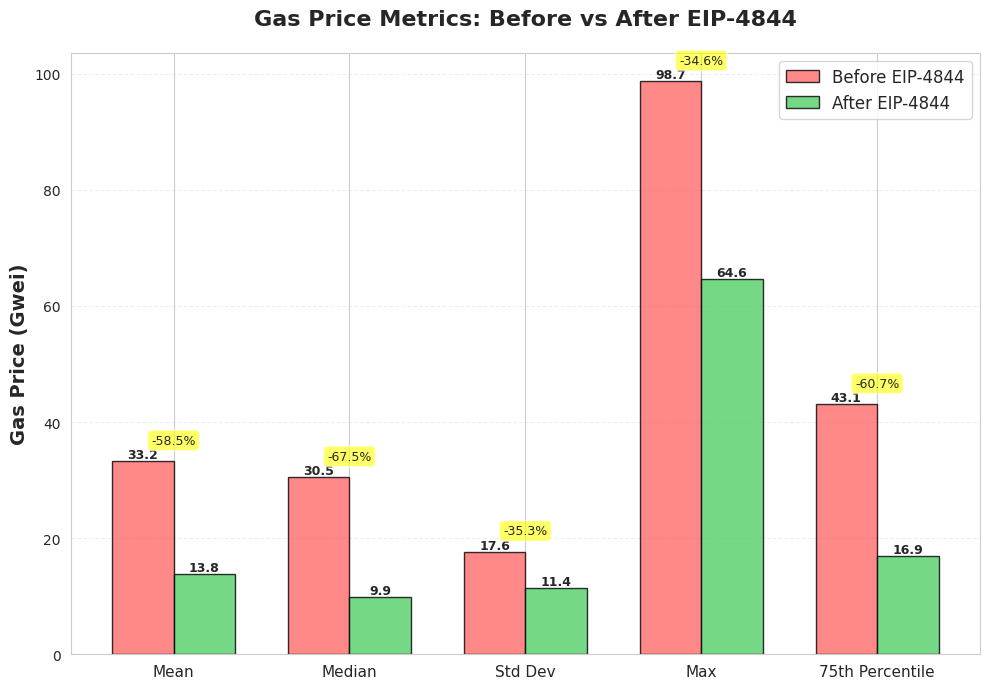

In [20]:
# ========================================
# GRAPH 1B: KEY METRICS BAR CHART (SEPARATE)
# ========================================

def plot_metrics_comparison(before, after):
    """
    Bar chart comparing key metrics before/after EIP-4844
    """

    fig, ax = plt.subplots(figsize=(10, 7))

    # Prepare data
    metrics = ['Mean', 'Median', 'Std Dev', 'Max', '75th Percentile']
    before_vals = [
        before['gas_price_gwei'].mean(),
        before['gas_price_gwei'].median(),
        before['gas_price_gwei'].std(),
        before['gas_price_gwei'].max(),
        before['gas_price_gwei'].quantile(0.75)
    ]
    after_vals = [
        after['gas_price_gwei'].mean(),
        after['gas_price_gwei'].median(),
        after['gas_price_gwei'].std(),
        after['gas_price_gwei'].max(),
        after['gas_price_gwei'].quantile(0.75)
    ]

    # Calculate percentage changes
    pct_changes = [((a - b) / b * 100) for b, a in zip(before_vals, after_vals)]

    # Create bar chart
    x = np.arange(len(metrics))
    width = 0.35

    bars1 = ax.bar(x - width/2, before_vals, width,
                   label='Before EIP-4844', color='#ff6b6b', alpha=0.8, edgecolor='black')
    bars2 = ax.bar(x + width/2, after_vals, width,
                   label='After EIP-4844', color='#51cf66', alpha=0.8, edgecolor='black')

    # Labels and title
    ax.set_ylabel('Gas Price (Gwei)', fontsize=14, fontweight='bold')
    ax.set_title('Gas Price Metrics: Before vs After EIP-4844',
                 fontsize=16, fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(metrics, fontsize=11)
    ax.legend(fontsize=12, loc='upper right')
    ax.grid(True, alpha=0.3, axis='y', linestyle='--')

    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.1f}',
                   ha='center', va='bottom', fontsize=9, fontweight='bold')

    # Add percentage change labels between bars
    for i, pct in enumerate(pct_changes):
        y_pos = max(before_vals[i], after_vals[i]) + 3
        ax.text(i, y_pos, f'{pct:+.1f}%',
               ha='center', fontsize=9,
               bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.6))

    plt.tight_layout()
    plt.savefig('graph2_metrics_comparison.png', dpi=300, bbox_inches='tight')
    print("✓ Graph 1B saved: graph2_metrics_comparison.png")
    plt.show()

# Generate Graph 1B
plot_metrics_comparison(gas_before, gas_after)

✓ Graph 2 saved: graph3_time_series.png


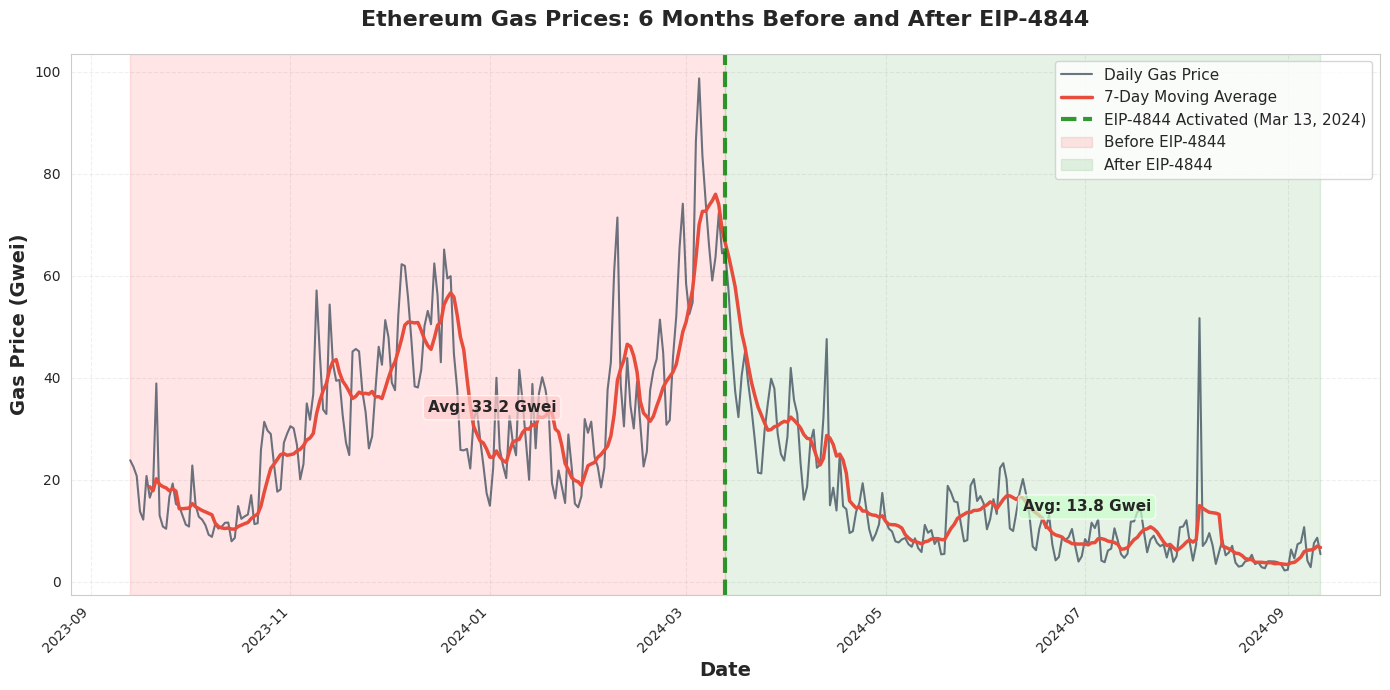

In [21]:
# ========================================
# GRAPH 2: TIME SERIES - FULL 12 MONTHS
# ========================================

def plot_time_series(before, after, dencun_date):
    """
    Time series showing gas prices over the full 12-month period
    With clear marking of EIP-4844 activation
    """

    fig, ax = plt.subplots(figsize=(14, 7))

    # Combine data for plotting
    full_data = pd.concat([before, after]).sort_values('date')

    # Plot the time series
    ax.plot(full_data['date'], full_data['gas_price_gwei'],
            linewidth=1.5, color='#2c3e50', alpha=0.7, label='Daily Gas Price')

    # Add 7-day moving average for trend
    full_data['ma_7'] = full_data['gas_price_gwei'].rolling(window=7).mean()
    ax.plot(full_data['date'], full_data['ma_7'],
            linewidth=2.5, color='#e74c3c', label='7-Day Moving Average')

    # Mark the EIP-4844 activation date
    ax.axvline(x=dencun_date, color='green', linewidth=3,
               linestyle='--', label='EIP-4844 Activated (Mar 13, 2024)', alpha=0.8)

    # Shade the before/after regions
    ax.axvspan(before['date'].min(), dencun_date,
               alpha=0.1, color='red', label='Before EIP-4844')
    ax.axvspan(dencun_date, after['date'].max(),
               alpha=0.1, color='green', label='After EIP-4844')

    # Labels and title
    ax.set_xlabel('Date', fontsize=14, fontweight='bold')
    ax.set_ylabel('Gas Price (Gwei)', fontsize=14, fontweight='bold')
    ax.set_title('Ethereum Gas Prices: 6 Months Before and After EIP-4844',
                 fontsize=16, fontweight='bold', pad=20)
    ax.legend(fontsize=11, loc='upper right')
    ax.grid(True, alpha=0.3, linestyle='--')

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')

    # Add annotations for average prices
    mid_before = before['date'].min() + (dencun_date - before['date'].min()) / 2
    mid_after = dencun_date + (after['date'].max() - dencun_date) / 2

    ax.annotate(f'Avg: {before["gas_price_gwei"].mean():.1f} Gwei',
                xy=(mid_before, before['gas_price_gwei'].mean()),
                fontsize=11, fontweight='bold',
                bbox=dict(boxstyle='round', facecolor='#ffcccc', alpha=0.7))

    ax.annotate(f'Avg: {after["gas_price_gwei"].mean():.1f} Gwei',
                xy=(mid_after, after['gas_price_gwei'].mean()),
                fontsize=11, fontweight='bold',
                bbox=dict(boxstyle='round', facecolor='#ccffcc', alpha=0.7))

    plt.tight_layout()
    plt.savefig('graph3_time_series.png', dpi=300, bbox_inches='tight')
    print("✓ Graph 2 saved: graph3_time_series.png")
    plt.show()

# Generate Graph 2
plot_time_series(gas_before, gas_after, DENCUN_UPGRADE)

✓ Graph 3 saved: graph4_distribution_histogram.png


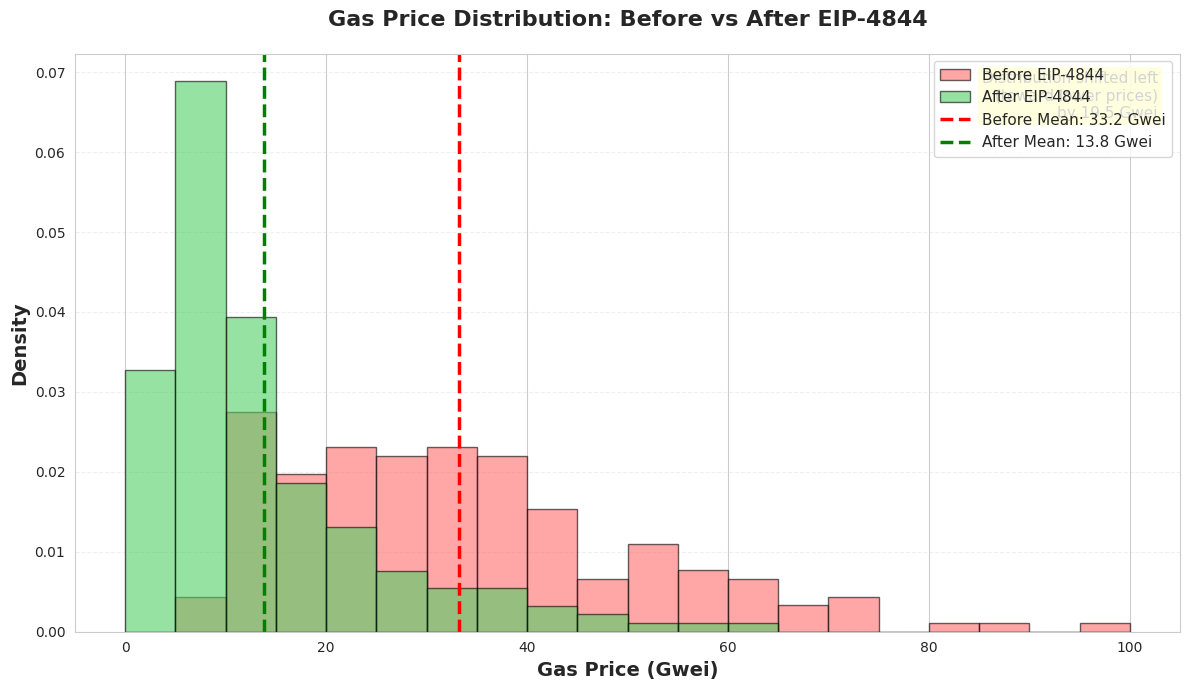

In [22]:
# ========================================
# GRAPH 3: DISTRIBUTION HISTOGRAM
# ========================================

def plot_distribution_histogram(before, after):
    """
    Overlapping histograms showing the distribution shift
    """

    fig, ax = plt.subplots(figsize=(12, 7))

    # Create histograms
    bins = np.arange(0, 105, 5)  # 5 Gwei bins from 0 to 100

    ax.hist(before['gas_price_gwei'], bins=bins,
            alpha=0.6, color='#ff6b6b', edgecolor='black',
            label='Before EIP-4844', density=True)

    ax.hist(after['gas_price_gwei'], bins=bins,
            alpha=0.6, color='#51cf66', edgecolor='black',
            label='After EIP-4844', density=True)

    # Add vertical lines for means
    ax.axvline(before['gas_price_gwei'].mean(), color='red',
               linestyle='--', linewidth=2.5, label=f'Before Mean: {before["gas_price_gwei"].mean():.1f} Gwei')
    ax.axvline(after['gas_price_gwei'].mean(), color='green',
               linestyle='--', linewidth=2.5, label=f'After Mean: {after["gas_price_gwei"].mean():.1f} Gwei')

    # Labels and title
    ax.set_xlabel('Gas Price (Gwei)', fontsize=14, fontweight='bold')
    ax.set_ylabel('Density', fontsize=14, fontweight='bold')
    ax.set_title('Gas Price Distribution: Before vs After EIP-4844',
                 fontsize=16, fontweight='bold', pad=20)
    ax.legend(fontsize=11, loc='upper right')
    ax.grid(True, alpha=0.3, linestyle='--', axis='y')

    # Add text annotation
    ax.text(0.98, 0.97,
            f'Distribution shifted left\n(toward lower prices)\nby {before["gas_price_gwei"].mean() - after["gas_price_gwei"].mean():.1f} Gwei',
            transform=ax.transAxes,
            fontsize=11,
            verticalalignment='top',
            horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.6))

    plt.tight_layout()
    plt.savefig('graph4_distribution_histogram.png', dpi=300, bbox_inches='tight')
    print("✓ Graph 3 saved: graph4_distribution_histogram.png")
    plt.show()

# Generate Graph 3
plot_distribution_histogram(gas_before, gas_after)

✓ Graph 4 saved: graph5_high_low_days.png


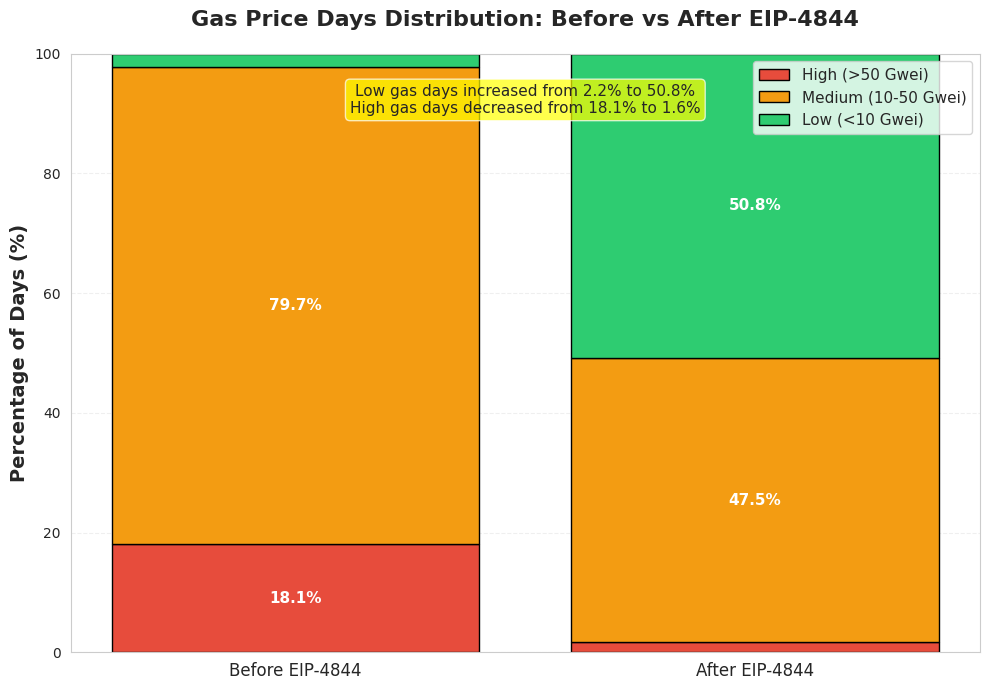

In [23]:
# ========================================
# GRAPH 4: HIGH VS LOW GAS DAYS
# ========================================

def plot_high_low_gas_days(before, after):
    """
    Bar chart showing the dramatic shift in expensive vs cheap days
    """

    fig, ax = plt.subplots(figsize=(10, 7))

    # Define thresholds
    high_threshold = 50  # Gwei
    low_threshold = 10   # Gwei

    # Count days in each category
    before_high = len(before[before['gas_price_gwei'] > high_threshold])
    before_low = len(before[before['gas_price_gwei'] < low_threshold])
    before_mid = len(before) - before_high - before_low

    after_high = len(after[after['gas_price_gwei'] > high_threshold])
    after_low = len(after[after['gas_price_gwei'] < low_threshold])
    after_mid = len(after) - after_high - after_low

    # Calculate percentages
    before_high_pct = before_high / len(before) * 100
    before_low_pct = before_low / len(before) * 100
    before_mid_pct = before_mid / len(before) * 100

    after_high_pct = after_high / len(after) * 100
    after_low_pct = after_low / len(after) * 100
    after_mid_pct = after_mid / len(after) * 100

    # Create stacked bar chart
    categories = ['Before EIP-4844', 'After EIP-4844']
    high_counts = [before_high_pct, after_high_pct]
    mid_counts = [before_mid_pct, after_mid_pct]
    low_counts = [before_low_pct, after_low_pct]

    x = np.arange(len(categories))

    p1 = ax.bar(x, high_counts, color='#e74c3c', edgecolor='black', label='High (>50 Gwei)')
    p2 = ax.bar(x, mid_counts, bottom=high_counts, color='#f39c12', edgecolor='black', label='Medium (10-50 Gwei)')
    p3 = ax.bar(x, low_counts, bottom=[h+m for h,m in zip(high_counts, mid_counts)],
                color='#2ecc71', edgecolor='black', label='Low (<10 Gwei)')

    # Labels and title
    ax.set_ylabel('Percentage of Days (%)', fontsize=14, fontweight='bold')
    ax.set_title('Gas Price Days Distribution: Before vs After EIP-4844',
                 fontsize=16, fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(categories, fontsize=12)
    ax.legend(fontsize=11, loc='upper right')
    ax.set_ylim(0, 100)
    ax.grid(True, alpha=0.3, axis='y', linestyle='--')

    # Add percentage labels on bars
    for i, (h, m, l) in enumerate(zip(high_counts, mid_counts, low_counts)):
        # High label
        if h > 3:
            ax.text(i, h/2, f'{h:.1f}%', ha='center', va='center',
                   fontsize=11, fontweight='bold', color='white')
        # Mid label
        if m > 3:
            ax.text(i, h + m/2, f'{m:.1f}%', ha='center', va='center',
                   fontsize=11, fontweight='bold', color='white')
        # Low label
        if l > 3:
            ax.text(i, h + m + l/2, f'{l:.1f}%', ha='center', va='center',
                   fontsize=11, fontweight='bold', color='white')

    # Add summary annotation
    ax.text(0.5, 0.95,
            f'Low gas days increased from {before_low_pct:.1f}% to {after_low_pct:.1f}%\n' +
            f'High gas days decreased from {before_high_pct:.1f}% to {after_high_pct:.1f}%',
            transform=ax.transAxes,
            fontsize=11,
            verticalalignment='top',
            horizontalalignment='center',
            bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))

    plt.tight_layout()
    plt.savefig('graph5_high_low_days.png', dpi=300, bbox_inches='tight')
    print("✓ Graph 4 saved: graph5_high_low_days.png")
    plt.show()

# Generate Graph 4
plot_high_low_gas_days(gas_before, gas_after)

In [18]:
# ========================================
# BLOCK 6: GENERATE SUMMARY REPORT
# ========================================

def generate_summary_report(before, after):
    """
    Create a comprehensive summary of all findings
    """

    print("\n" + "="*70)
    print("FINAL RESEARCH SUMMARY")
    print("EIP-4844 Gas Market Impact Analysis")
    print("="*70)

    print("\n📅 STUDY PERIOD:")
    print(f"   Before: {before['date'].min().date()} to {before['date'].max().date()} ({len(before)} days)")
    print(f"   After:  {after['date'].min().date()} to {after['date'].max().date()} ({len(after)} days)")

    print("\n💰 GAS PRICE CHANGES:")
    print(f"   Mean:     {before['gas_price_gwei'].mean():.2f} → {after['gas_price_gwei'].mean():.2f} Gwei ({((after['gas_price_gwei'].mean() - before['gas_price_gwei'].mean()) / before['gas_price_gwei'].mean() * 100):+.1f}%)")
    print(f"   Median:   {before['gas_price_gwei'].median():.2f} → {after['gas_price_gwei'].median():.2f} Gwei ({((after['gas_price_gwei'].median() - before['gas_price_gwei'].median()) / before['gas_price_gwei'].median() * 100):+.1f}%)")
    print(f"   Std Dev:  {before['gas_price_gwei'].std():.2f} → {after['gas_price_gwei'].std():.2f} Gwei ({((after['gas_price_gwei'].std() - before['gas_price_gwei'].std()) / before['gas_price_gwei'].std() * 100):+.1f}%)")
    print(f"   Max:      {before['gas_price_gwei'].max():.2f} → {after['gas_price_gwei'].max():.2f} Gwei ({((after['gas_price_gwei'].max() - before['gas_price_gwei'].max()) / before['gas_price_gwei'].max() * 100):+.1f}%)")
    print(f"   Min:      {before['gas_price_gwei'].min():.2f} → {after['gas_price_gwei'].min():.2f} Gwei ({((after['gas_price_gwei'].min() - before['gas_price_gwei'].min()) / before['gas_price_gwei'].min() * 100):+.1f}%)")

    print("\n📊 MARKET STABILITY:")
    cv_before = before['gas_price_gwei'].std() / before['gas_price_gwei'].mean()
    cv_after = after['gas_price_gwei'].std() / after['gas_price_gwei'].mean()
    print(f"   Coefficient of Variation (Before): {cv_before:.4f}")
    print(f"   Coefficient of Variation (After):  {cv_after:.4f}")
    print(f"   Change: {((cv_after - cv_before) / cv_before * 100):+.1f}%")

    print("\n🔥 HIGH GAS DAYS (>50 Gwei):")
    high_before = len(before[before['gas_price_gwei'] > 50])
    high_after = len(after[after['gas_price_gwei'] > 50])
    print(f"   Before: {high_before} days ({high_before/len(before)*100:.1f}%)")
    print(f"   After:  {high_after} days ({high_after/len(after)*100:.1f}%)")
    print(f"   Reduction: {((high_after - high_before) / high_before * 100):+.1f}%")

    print("\n💚 LOW GAS DAYS (<10 Gwei):")
    low_before = len(before[before['gas_price_gwei'] < 10])
    low_after = len(after[after['gas_price_gwei'] < 10])
    print(f"   Before: {low_before} days ({low_before/len(before)*100:.1f}%)")
    print(f"   After:  {low_after} days ({low_after/len(after)*100:.1f}%)")
    print(f"   Increase: {((low_after - low_before) / low_before * 100):+.1f}%")

    print("\n🎯 KEY FINDINGS:")
    print(f"   1. Gas prices dropped by {abs((after['gas_price_gwei'].mean() - before['gas_price_gwei'].mean()) / before['gas_price_gwei'].mean() * 100):.1f}% on average")
    print(f"   2. Market volatility decreased by {abs((after['gas_price_gwei'].std() - before['gas_price_gwei'].std()) / before['gas_price_gwei'].std() * 100):.1f}%")
    print(f"   3. Expensive days (>50 Gwei) reduced by {abs((high_after - high_before) / high_before * 100):.1f}%")
    print(f"   4. Cheap days (<10 Gwei) increased by {(low_after - low_before) / low_before * 100:.1f}%")
    print(f"   5. Median user paid {abs((after['gas_price_gwei'].median() - before['gas_price_gwei'].median()) / before['gas_price_gwei'].median() * 100):.1f}% less")

# Generate final summary
generate_summary_report(gas_before, gas_after)


FINAL RESEARCH SUMMARY
EIP-4844 Gas Market Impact Analysis

📅 STUDY PERIOD:
   Before: 2023-09-13 to 2024-03-12 (182 days)
   After:  2024-03-13 to 2024-09-11 (183 days)

💰 GAS PRICE CHANGES:
   Mean:     33.24 → 13.78 Gwei (-58.5%)
   Median:   30.49 → 9.91 Gwei (-67.5%)
   Std Dev:  17.65 → 11.42 Gwei (-35.3%)
   Max:      98.68 → 64.57 Gwei (-34.6%)
   Min:      7.94 → 2.22 Gwei (-72.1%)

📊 MARKET STABILITY:
   Coefficient of Variation (Before): 0.5309
   Coefficient of Variation (After):  0.8284
   Change: +56.0%

🔥 HIGH GAS DAYS (>50 Gwei):
   Before: 33 days (18.1%)
   After:  3 days (1.6%)
   Reduction: -90.9%

💚 LOW GAS DAYS (<10 Gwei):
   Before: 4 days (2.2%)
   After:  93 days (50.8%)
   Increase: +2225.0%

🎯 KEY FINDINGS:
   1. Gas prices dropped by 58.5% on average
   2. Market volatility decreased by 35.3%
   3. Expensive days (>50 Gwei) reduced by 90.9%
   4. Cheap days (<10 Gwei) increased by 2225.0%
   5. Median user paid 67.5% less
